In [4]:
import numpy as np
import random
import torch
torch.set_default_dtype(torch.float64)
from scipy.sparse.linalg import LinearOperator
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt

Tout d'abord on crée la fonction

In [5]:


class Problem:
    def __init__(self, U, V, mu, nu, q, epsilon):
        self.U = U  # (nb_receivers, nb_states, nb_actions)
        self.V = V  # (nb_states, nb_actions)
        self.mu = mu  # (nb_states,)
        self.nu = nu  # (nb_receivers, nb_states)
        self.q = q  # (nb_receivers, nb_messages, nb_actions)
        self.epsilon = epsilon  # (nb_receivers,)
        self.nb_receivers, self.nb_states, self.nb_actions = U.shape
        self.nb_messages = q.shape[1]
        self.size = self.nb_receivers * self.nb_states * self.nb_messages
        self.shape = (self.nb_receivers, self.nb_states, self.nb_messages)
        self.check()

    def check(self):
        for receiver_idx in range(self.nb_receivers):
            self.debug_shape(self.U[receiver_idx], [self.nb_states, self.nb_actions])
            self.debug_shape(self.V, [self.nb_states, self.nb_actions])
            self.debug_shape(self.mu, [self.nb_states])
            self.debug_shape(self.nu[receiver_idx], [self.nb_states])
            self.debug_shape(self.q[receiver_idx], [self.nb_messages, self.nb_actions])

    def debug_shape(self, vect, target_shape):
        if list(vect.shape) != target_shape:
            print(f"Found vector of size {vect.shape}, expected {target_shape}")
            assert False

    def verbose(self, pi):
        print(f"We have (state, message, action) = ({self.nb_states}, {self.nb_messages}, {self.nb_actions})")
        self.debug_shape(pi, [self.nb_states, self.nb_messages])
        for receiver_idx in range(self.nb_receivers):
            theta = self.compute_theta(self.compute_g(pi, receiver_idx), receiver_idx)
            self.debug_shape(theta, [self.nb_messages, self.nb_actions])
            print(f"We have 1 = {pi.sum(axis=1)}")
            print(f"We have 1 = {theta.sum(axis=1)}")
            print("Theta", theta)
        print("Objective", self.objective(pi, range(self.nb_receivers)))

    def compute_g(self, pi, receiver_idx):
        denominator = (pi * self.nu[receiver_idx][:, None]).sum(axis=0)
        self.debug_shape(denominator, [self.nb_messages])
        g = (pi[:, :, None] * self.nu[receiver_idx][:, None, None] * self.U[receiver_idx][:, None, :]).sum(axis=0)
        self.debug_shape(g, [self.nb_messages, self.nb_actions])
        return g / denominator[:, None]

    def compute_theta(self, g, receiver_idx):
        max_g, _ = g.max(axis=1)
        exp = torch.exp((g - max_g[:, None]) / self.epsilon[receiver_idx])
        self.debug_shape(exp, [self.nb_messages, self.nb_actions])
        theta = self.q[receiver_idx] * exp
        denom = theta.sum(axis=1)
        return theta / denom[:, None]

    def objective(self, pi, receivers_batch):
        total_objective = 0
        for receiver_idx in receivers_batch:
            g = self.compute_g(pi, receiver_idx)
            theta = self.compute_theta(g, receiver_idx)
            total_objective += (theta[None, :, :] * pi[:, :, None] * self.mu[:, None, None] * self.V[:, None, :]).sum()
        return total_objective / len(receivers_batch)

    def value(self, x, receivers_batch=None):
        if receivers_batch is None:
            receivers_batch = range(self.nb_receivers)
        x = x.reshape(self.nb_states, self.nb_messages)
        x = torch.from_numpy(x).requires_grad_(True)
        f = self.objective(x, receivers_batch)
        f.backward()
        df = x.grad
        return -f.item(), -df.numpy()

    def project(self, x):
        x = torch.from_numpy(x).reshape(self.nb_states, self.nb_messages)
        x_projected = torch.zeros_like(x)
        for i in range(x.shape[0]):
            row = x[i, :]
            sorted_row, _ = torch.sort(row, descending=True)
            cumulative_sum = torch.cumsum(sorted_row, dim=0)
            rho = torch.nonzero(sorted_row * torch.arange(1, len(row) + 1) > (cumulative_sum - 1), as_tuple=False).max()
            theta = (cumulative_sum[rho] - 1) / (rho + 1)
            x_projected[i, :] = torch.clamp(row - theta, min=0)
        return x_projected.numpy()

    def project_tangent(self, x, d):
        d2 = d - d.mean(axis=1)[:, None]
        d2[(x == 0) * (d2 < 0)] = 0.
        d2[(x == 1) * (d2 > 0)] = 0.
        return d2


In [16]:


def dot(a, b):
    return (a * b).sum()

def ls_wolfe(x, function, step, descent, f, df, batch):
    """
    Wolfe line search for stochastic gradient descent.
    """
    step_min, step_max = 0., np.inf
    scal = dot(df, descent)
    if scal > 0:
        print('WARNING with scal', scal)
    step2 = step
    eps1, eps2 = 1.e-4, 0.9  # Wolfe condition parameters
    i = 0
    while i < 100:
        i += 1
        x2 = function.project(x + step2 * descent)
        f2, df2 = function.value(x2, batch)
        if dot(x2 - x, df) >= 0:
            print('We have a problem', dot(x2 - x, df), dot(descent, df))
        if f2 > f + eps1 * dot(x2 - x, df):  # step is too big, decrease it
            step_max = step2
            step2 = 0.5 * (step_min + step_max)
        else:
            if dot(df2, x2 - x) < eps2 * dot(df, x2 - x):  # step is too small, increase it
                step_min = step2
                step2 = min(0.5 * (step_min + step_max), 2 * step_min)
            else:
                return x2, f2, df2, step2
    print('We do not exit Wolfe')
    return x2, f2, df2, step2


def dot(a,b) :
    return (a*b).sum()

def ls_wolfe(x,function,step,descent,f,df,batch) :
    step_min,step_max=0.,np.inf
    scal=dot(df,descent)
    if scal > 0 :
        print('WARNING with scal',scal)
    step2=step
    eps1,eps2=1.e-4,0.9
    i=0
    while i<100 :
        i=i+1
        x2=function.project(x+step2*descent)
        f2,df2=function.value(x2,batch)
        if dot(x2-x,df) >=0 :
            print('We have a problem',dot(x2-x,df),dot(descent,df))
        if f2>f+eps1*dot(x2-x,df) : # step is too big, decrease it
            step_max=step2
            step2=0.5*(step_min+step_max)
        else :
            if dot(df2,x2-x) < eps2*dot(df,x2-x) : # step is too small, increase it
                step_min=step2
                step2=min(0.5*(step_min+step_max),2*step_min)
            else :
                return x2,f2,df2,step2
    print('We do not exit Wolfe')
    print(f2>f+eps1*step2*scal,dot(df2,descent) < eps2*scal)
    return x2,f2,df2,step2




def optimize(function,itermax = 5000,tol=1.e-6,batch_size = 100,verbose=True):
    np.random.seed(42)
    receivers = list(range(function.nb_receivers))
    x = np.random.randn(function.nb_states, function.nb_messages)
    x=function.project(x)
    np.random.seed(None)
    list_costs=[]
    list_grads=[]
    nbiter = 0
    batch = np.random.choice(receivers, size=batch_size, replace=False)
    f,df=function.value(x,batch)
    df_tangent=function.project_tangent(x,-df)
    norm_grad=np.linalg.norm(df_tangent)
    err=2*tol
    if verbose :
        print('iter={:4d} f={:1.3e} df={:1.3e}'.format(nbiter,f,err))
    list_costs.append(f)
    list_grads.append(norm_grad)
    while (err > tol) and (nbiter < itermax):
        descent=-df
        x_old=np.copy(x)
        x,f,df,step = ls_wolfe(x, function,1., descent,f,df,batch)
        batch = np.random.choice(receivers, size=batch_size, replace=False)
        norm_grad = np.linalg.norm(function.project_tangent(x,-df))
        list_costs.append(f)
        list_grads.append(norm_grad)
        err=norm_grad
        nbiter+=1
        if verbose :
            print('iter={:4d} f={:1.3e} err={:1.3e} s={:1.3e}'.format(nbiter,f,err,step))
        if (err <= tol):
            if verbose : print("Success !!! Algorithm converged !!!")
            return x,list_costs,list_grads
    if verbose : print("FAILED to converge")


def stochastic_optimize(function,itermax = 5000,tol=1.e-5,batch_size = 100,verbose=True):
    np.random.seed(42)
    receivers = list(range(function.nb_receivers))
    x = np.random.randn(function.nb_states, function.nb_messages)
    x=function.project(x)
    np.random.seed(None)
    list_costs=[]
    list_grads=[]
    nbiter = 0
    batch = np.random.choice(receivers, size=batch_size, replace=False)
    f,df=function.value(x,batch)
    df_tangent=function.project_tangent(x,-df)
    norm_grad=np.linalg.norm(df_tangent)
    err=2*tol
    if verbose :
        print('iter={:4d} f={:1.3e} df={:1.3e}'.format(nbiter,f,err))
    list_costs.append(f)
    list_grads.append(norm_grad)
    while (err > tol) and (nbiter < itermax):
        nbiter+=1
        x_old=np.copy(x)
        batch = np.random.choice(receivers, size=batch_size, replace=False)
        x = function.project(x - ( 0.01 ) * df)
        f,df = function.value(x,batch)
        norm_grad = np.linalg.norm(function.project_tangent(x,-df))
        list_costs.append(f)
        list_grads.append(norm_grad)
        err=norm_grad
        if verbose :
            print('iter={:4d} f={:1.3e} err={:1.3e}'.format(nbiter,f,err))
        if (err <= tol):
            if verbose : print("Success !!! Algorithm converged !!!")
            return x,list_costs,list_grads
    if verbose : print("FAILED to converge")


def stochastic_optimize_epochs(function, max_epochs=20, batch_size=100, verbose=True,seed=None):
    import numpy as np

    np.random.seed(42)
    receivers = list(range(function.nb_receivers))
    x = np.random.randn(function.nb_states, function.nb_messages)
    x = function.project(x)
    np.random.seed(seed)

    list_costs = []
    list_grads = []

    for epoch in range(max_epochs):
        # Shuffle the dataset
        np.random.shuffle(receivers)
        total_batches = len(receivers) // batch_size

        for batch_idx in range(total_batches):
            batch = receivers[batch_idx * batch_size:(batch_idx + 1) * batch_size]
            f, df = function.value(x, batch)
            df_tangent = function.project_tangent(x, -df)
            x = function.project(x - 0.001 * df)

        # At the end of the epoch, calculate f and gradient for the full dataset
        f, df = function.value(x, receivers)
        norm_grad = np.linalg.norm(function.project_tangent(x, -df))

        list_costs.append(f)
        list_grads.append(norm_grad)

        if verbose:
            print(f"Epoch {epoch + 1}/{max_epochs} - f: {f:.3e} - grad_norm: {norm_grad:.3e}")


    return x, list_costs, list_grads



On crée 1000 variations d'un receiver de base

In [40]:
alpha = 0.7
beta = 0.9

# Initialisation des matrices de base
nb_receivers = 1000
nb_states = 2
nb_actions = 2
nb_messages = 2

U_base = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float64)  # Matrice U de base
nu_base = torch.tensor([alpha, 1 - alpha], dtype=torch.float64)  # Distribution de probabilité de base pour nu
q_base = torch.tensor([beta, 1 - beta], dtype=torch.float64)  # Une seule ligne pour q de base
epsilon_base = 1e-2  # Valeur de base pour epsilon

mu = torch.tensor([alpha, 1 - alpha])


def add_noise_to_distribution(base_vector, noise_level):
    noise = noise_level * torch.randn_like(base_vector)
    
    normalized_vector = torch.softmax(torch.log(base_vector) + noise, dim=0)
    
    return normalized_vector




# Génération des variations
noise_level_U = 0.1
noise_level_nu = 0.2
noise_level_q = 0.2
noise_level_epsilon = 0.01

torch.manual_seed(42)
np.random.seed(42)

U = torch.stack([U_base + noise_level_U * torch.randn_like(U_base) for _ in range(nb_receivers)])
nu = torch.stack([add_noise_to_distribution(nu_base, noise_level_nu) for _ in range(nb_receivers)])
q = torch.stack([add_noise_to_distribution(q_base, noise_level_q).expand(nb_messages, -1) for _ in range(nb_receivers)])
epsilon = torch.tensor([epsilon_base + noise_level_epsilon * np.random.randn() for _ in range(nb_receivers)])
epsilon = torch.clamp(epsilon, min=1e-8)  # Assurez-vous que epsilon reste positif

# Vérifications
print("Exemple de U :", U[0])
print("Exemple de nu (somme = 1) :", nu[0], "Somme =", nu[0].sum())
print("Exemple de q (lignes identiques, somme = 1) :", q[0], "Somme des lignes =", q[0].sum(dim=1))
print("Exemple de epsilon :", epsilon[:10])

V = torch.tensor([[0.0, 1.0],
                  [0.0, 1.0]])

Exemple de U : tensor([[1.0337, 0.0129],
        [0.0234, 1.0230]])
Exemple de nu (somme = 1) : tensor([0.6312, 0.3688]) Somme = tensor(1.)
Exemple de q (lignes identiques, somme = 1) : tensor([[0.9003, 0.0997],
        [0.9003, 0.0997]]) Somme des lignes = tensor([1., 1.])
Exemple de epsilon : tensor([0.0150, 0.0086, 0.0165, 0.0252, 0.0077, 0.0077, 0.0258, 0.0177, 0.0053,
        0.0154])


On optimise la "vraie" fonction (moyenne sur tous les Receivers) pour comparer ensuite avec l'optimisation sur des batchs

In [41]:
# Création de l'objet Problem avec les données générées
P = Problem(U, V, mu, nu, q, epsilon)

#x,costs,grad=stochastic_optimize(P,tol=1.e-5,verbose=True,batch_size = 1000)

In [42]:
x0,costs,grad = optimize(P,batch_size = 1000,tol = 1e-4)

iter=   0 f=-4.024e-01 df=2.000e-04
iter=   1 f=-4.197e-01 err=2.805e-01 s=5.000e-01
iter=   2 f=-4.280e-01 err=3.281e-01 s=5.000e-01
iter=   3 f=-4.369e-01 err=7.357e-02 s=2.500e-01
iter=   4 f=-4.372e-01 err=6.050e-02 s=6.250e-02
iter=   5 f=-4.373e-01 err=3.320e-02 s=3.125e-02
iter=   6 f=-4.373e-01 err=2.217e-02 s=1.562e-02
iter=   7 f=-4.373e-01 err=1.380e-02 s=1.562e-02
iter=   8 f=-4.373e-01 err=1.174e-02 s=5.859e-03
iter=   9 f=-4.373e-01 err=1.770e-01 s=1.205e-03
iter=  10 f=-4.373e-01 err=1.137e-02 s=4.768e-07
iter=  11 f=-4.373e-01 err=3.450e-03 s=5.722e-06
iter=  12 f=-4.373e-01 err=2.215e-03 s=9.537e-07
iter=  13 f=-4.373e-01 err=1.762e-03 s=9.537e-07
iter=  14 f=-4.373e-01 err=1.287e-03 s=9.537e-07
iter=  15 f=-4.373e-01 err=1.020e-03 s=9.537e-07
iter=  16 f=-4.373e-01 err=7.704e-04 s=9.537e-07
iter=  17 f=-4.373e-01 err=6.077e-04 s=9.537e-07
iter=  18 f=-4.373e-01 err=4.653e-04 s=9.537e-07
iter=  19 f=-4.373e-01 err=3.654e-04 s=9.537e-07
iter=  20 f=-4.373e-01 err=2.818e

In [43]:
true_max = -costs[-1]

true_max

0.4373371819428475

In [44]:
x1,costs1,grad1=stochastic_optimize_epochs(P,batch_size = 10,seed=42)

Epoch 1/20 - f: -4.142e-01 - grad_norm: 3.288e-01
Epoch 2/20 - f: -4.236e-01 - grad_norm: 3.228e-01
Epoch 3/20 - f: -4.331e-01 - grad_norm: 3.034e-01
Epoch 4/20 - f: -4.352e-01 - grad_norm: 1.538e-01
Epoch 5/20 - f: -4.369e-01 - grad_norm: 1.310e-01
Epoch 6/20 - f: -4.365e-01 - grad_norm: 4.418e-02
Epoch 7/20 - f: -4.366e-01 - grad_norm: 4.246e-02
Epoch 8/20 - f: -4.368e-01 - grad_norm: 6.822e-02
Epoch 9/20 - f: -4.373e-01 - grad_norm: 5.335e-02
Epoch 10/20 - f: -4.369e-01 - grad_norm: 1.153e-02
Epoch 11/20 - f: -4.373e-01 - grad_norm: 4.386e-02
Epoch 12/20 - f: -4.368e-01 - grad_norm: 4.591e-02
Epoch 13/20 - f: -4.369e-01 - grad_norm: 4.821e-03
Epoch 14/20 - f: -4.373e-01 - grad_norm: 1.460e-02
Epoch 15/20 - f: -4.366e-01 - grad_norm: 9.351e-02
Epoch 16/20 - f: -4.373e-01 - grad_norm: 4.784e-02
Epoch 17/20 - f: -4.372e-01 - grad_norm: 6.648e-02
Epoch 18/20 - f: -4.372e-01 - grad_norm: 5.625e-02
Epoch 19/20 - f: -4.369e-01 - grad_norm: 9.581e-03
Epoch 20/20 - f: -4.368e-01 - grad_norm:

In [45]:
costs1 = -np.array(costs1)
costs1

array([0.41423669, 0.42357742, 0.4330808 , 0.43515749, 0.43691056,
       0.4364624 , 0.43662261, 0.43681497, 0.43725981, 0.43685842,
       0.43729211, 0.43682701, 0.43686023, 0.43733554, 0.43660563,
       0.4372802 , 0.4371807 , 0.43724675, 0.43685895, 0.43684438])

In [46]:
x2,costs2,grad2=stochastic_optimize_epochs(P,batch_size = 10,seed=43)

Epoch 1/20 - f: -4.140e-01 - grad_norm: 3.267e-01
Epoch 2/20 - f: -4.237e-01 - grad_norm: 3.110e-01
Epoch 3/20 - f: -4.327e-01 - grad_norm: 3.020e-01
Epoch 4/20 - f: -4.349e-01 - grad_norm: 1.067e-01
Epoch 5/20 - f: -4.352e-01 - grad_norm: 1.554e-01
Epoch 6/20 - f: -4.371e-01 - grad_norm: 1.094e-01
Epoch 7/20 - f: -4.365e-01 - grad_norm: 3.599e-02
Epoch 8/20 - f: -4.367e-01 - grad_norm: 4.792e-02
Epoch 9/20 - f: -4.372e-01 - grad_norm: 6.938e-02
Epoch 10/20 - f: -4.368e-01 - grad_norm: 3.864e-02
Epoch 11/20 - f: -4.368e-01 - grad_norm: 5.852e-02
Epoch 12/20 - f: -4.373e-01 - grad_norm: 3.860e-02
Epoch 13/20 - f: -4.373e-01 - grad_norm: 3.132e-02
Epoch 14/20 - f: -4.368e-01 - grad_norm: 6.613e-02
Epoch 15/20 - f: -4.368e-01 - grad_norm: 6.825e-02
Epoch 16/20 - f: -4.373e-01 - grad_norm: 5.198e-02
Epoch 17/20 - f: -4.372e-01 - grad_norm: 6.827e-02
Epoch 18/20 - f: -4.372e-01 - grad_norm: 5.703e-02
Epoch 19/20 - f: -4.368e-01 - grad_norm: 7.738e-02
Epoch 20/20 - f: -4.373e-01 - grad_norm:

In [47]:
costs2 = -np.array(costs2)
costs2

array([0.41399313, 0.42373423, 0.43274563, 0.43490471, 0.4352432 ,
       0.43710009, 0.43650535, 0.43665738, 0.43715227, 0.43683686,
       0.43680469, 0.43730494, 0.43731836, 0.43678695, 0.43681533,
       0.43726538, 0.43716391, 0.43724293, 0.43675075, 0.4372578 ])

In [48]:
x3,costs3,grad3=stochastic_optimize_epochs(P,batch_size = 10,seed=44)

Epoch 1/20 - f: -4.141e-01 - grad_norm: 3.309e-01
Epoch 2/20 - f: -4.239e-01 - grad_norm: 3.121e-01
Epoch 3/20 - f: -4.316e-01 - grad_norm: 3.375e-01
Epoch 4/20 - f: -4.347e-01 - grad_norm: 1.369e-01
Epoch 5/20 - f: -4.349e-01 - grad_norm: 9.778e-02
Epoch 6/20 - f: -4.349e-01 - grad_norm: 1.459e-01
Epoch 7/20 - f: -4.361e-01 - grad_norm: 1.634e-01
Epoch 8/20 - f: -4.366e-01 - grad_norm: 3.437e-02
Epoch 9/20 - f: -4.367e-01 - grad_norm: 5.102e-02
Epoch 10/20 - f: -4.372e-01 - grad_norm: 5.879e-02
Epoch 11/20 - f: -4.372e-01 - grad_norm: 5.866e-02
Epoch 12/20 - f: -4.373e-01 - grad_norm: 4.142e-02
Epoch 13/20 - f: -4.368e-01 - grad_norm: 4.752e-02
Epoch 14/20 - f: -4.373e-01 - grad_norm: 4.887e-02
Epoch 15/20 - f: -4.368e-01 - grad_norm: 5.550e-02
Epoch 16/20 - f: -4.373e-01 - grad_norm: 1.814e-02
Epoch 17/20 - f: -4.373e-01 - grad_norm: 3.581e-02
Epoch 18/20 - f: -4.373e-01 - grad_norm: 2.883e-02
Epoch 19/20 - f: -4.370e-01 - grad_norm: 7.549e-02
Epoch 20/20 - f: -4.369e-01 - grad_norm:

In [49]:
costs3 = -np.array(costs3)
costs3

array([0.41406196, 0.42391705, 0.43164857, 0.43468154, 0.43489278,
       0.43487895, 0.43609712, 0.43655467, 0.43667722, 0.43723371,
       0.43723439, 0.43729842, 0.43682455, 0.43727677, 0.43681074,
       0.43733318, 0.4373106 , 0.43732199, 0.43704027, 0.43685941])

In [50]:
x4,costs4,grad4=stochastic_optimize_epochs(P,batch_size = 10,seed=45)

Epoch 1/20 - f: -4.140e-01 - grad_norm: 3.264e-01
Epoch 2/20 - f: -4.239e-01 - grad_norm: 3.142e-01
Epoch 3/20 - f: -4.330e-01 - grad_norm: 3.072e-01
Epoch 4/20 - f: -4.329e-01 - grad_norm: 1.921e-01
Epoch 5/20 - f: -4.348e-01 - grad_norm: 5.954e-02
Epoch 6/20 - f: -4.350e-01 - grad_norm: 1.576e-01
Epoch 7/20 - f: -4.364e-01 - grad_norm: 6.403e-02
Epoch 8/20 - f: -4.367e-01 - grad_norm: 4.891e-02
Epoch 9/20 - f: -4.371e-01 - grad_norm: 7.075e-02
Epoch 10/20 - f: -4.373e-01 - grad_norm: 5.523e-02
Epoch 11/20 - f: -4.372e-01 - grad_norm: 6.481e-02
Epoch 12/20 - f: -4.368e-01 - grad_norm: 5.243e-02
Epoch 13/20 - f: -4.373e-01 - grad_norm: 3.356e-02
Epoch 14/20 - f: -4.373e-01 - grad_norm: 4.080e-02
Epoch 15/20 - f: -4.368e-01 - grad_norm: 5.562e-02
Epoch 16/20 - f: -4.368e-01 - grad_norm: 3.327e-02
Epoch 17/20 - f: -4.372e-01 - grad_norm: 6.842e-02
Epoch 18/20 - f: -4.369e-01 - grad_norm: 7.330e-02
Epoch 19/20 - f: -4.373e-01 - grad_norm: 4.988e-02
Epoch 20/20 - f: -4.371e-01 - grad_norm:

In [51]:
costs4 = -np.array(costs4)
costs4

array([0.41402428, 0.42387144, 0.43301267, 0.43290037, 0.43483759,
       0.43495223, 0.43638557, 0.43666367, 0.43713599, 0.43725158,
       0.43719446, 0.43681639, 0.43731468, 0.43729992, 0.43681051,
       0.43684295, 0.43716247, 0.43688659, 0.43727327, 0.4370695 ])

In [52]:
x5,costs5,grad5=stochastic_optimize_epochs(P,batch_size = 10,seed=46, max_epochs = 20)

Epoch 1/20 - f: -4.140e-01 - grad_norm: 3.311e-01
Epoch 2/20 - f: -4.238e-01 - grad_norm: 3.188e-01
Epoch 3/20 - f: -4.318e-01 - grad_norm: 3.351e-01
Epoch 4/20 - f: -4.347e-01 - grad_norm: 1.266e-01
Epoch 5/20 - f: -4.347e-01 - grad_norm: 1.336e-01
Epoch 6/20 - f: -4.367e-01 - grad_norm: 1.454e-01
Epoch 7/20 - f: -4.368e-01 - grad_norm: 7.888e-02
Epoch 8/20 - f: -4.365e-01 - grad_norm: 4.037e-02
Epoch 9/20 - f: -4.367e-01 - grad_norm: 5.725e-02
Epoch 10/20 - f: -4.371e-01 - grad_norm: 7.228e-02
Epoch 11/20 - f: -4.373e-01 - grad_norm: 3.681e-02
Epoch 12/20 - f: -4.371e-01 - grad_norm: 7.358e-02
Epoch 13/20 - f: -4.368e-01 - grad_norm: 3.020e-02
Epoch 14/20 - f: -4.373e-01 - grad_norm: 4.922e-02
Epoch 15/20 - f: -4.373e-01 - grad_norm: 2.684e-02
Epoch 16/20 - f: -4.366e-01 - grad_norm: 9.148e-02
Epoch 17/20 - f: -4.373e-01 - grad_norm: 3.707e-02
Epoch 18/20 - f: -4.373e-01 - grad_norm: 1.806e-02
Epoch 19/20 - f: -4.368e-01 - grad_norm: 4.874e-02
Epoch 20/20 - f: -4.372e-01 - grad_norm:

In [53]:
costs5 = -np.array(costs5)
costs5

array([0.41402957, 0.42375855, 0.43179105, 0.43474741, 0.43470772,
       0.43670593, 0.43679589, 0.43647951, 0.43671958, 0.43711452,
       0.43730865, 0.43709202, 0.43684601, 0.43727559, 0.43732459,
       0.43664948, 0.43730813, 0.43733324, 0.43682262, 0.4371858 ])

In [54]:
trajectoires = np.array([costs1,costs2,costs3,costs4,costs5])
trajectoires

array([[0.41423669, 0.42357742, 0.4330808 , 0.43515749, 0.43691056,
        0.4364624 , 0.43662261, 0.43681497, 0.43725981, 0.43685842,
        0.43729211, 0.43682701, 0.43686023, 0.43733554, 0.43660563,
        0.4372802 , 0.4371807 , 0.43724675, 0.43685895, 0.43684438],
       [0.41399313, 0.42373423, 0.43274563, 0.43490471, 0.4352432 ,
        0.43710009, 0.43650535, 0.43665738, 0.43715227, 0.43683686,
        0.43680469, 0.43730494, 0.43731836, 0.43678695, 0.43681533,
        0.43726538, 0.43716391, 0.43724293, 0.43675075, 0.4372578 ],
       [0.41406196, 0.42391705, 0.43164857, 0.43468154, 0.43489278,
        0.43487895, 0.43609712, 0.43655467, 0.43667722, 0.43723371,
        0.43723439, 0.43729842, 0.43682455, 0.43727677, 0.43681074,
        0.43733318, 0.4373106 , 0.43732199, 0.43704027, 0.43685941],
       [0.41402428, 0.42387144, 0.43301267, 0.43290037, 0.43483759,
        0.43495223, 0.43638557, 0.43666367, 0.43713599, 0.43725158,
        0.43719446, 0.43681639, 0.43731468, 0

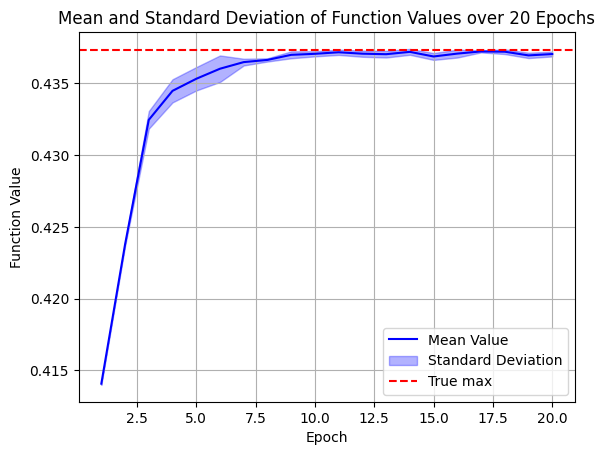

In [55]:

# Calculating the mean and standard deviation across the 5 trajectories
mean_values = trajectoires.mean(axis=0)
std_values = trajectoires.std(axis=0)

# Adding a horizontal dashed red line at the mean of the mean values
#plt.figure(figsize=(10, 6))
epochs = range(1, 21)
plt.plot(epochs, mean_values, label="Mean Value", color="blue", linewidth=1.5)
plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, color="blue", alpha=0.3, label="Standard Deviation")
plt.axhline(y=true_max, color='red', linestyle='--', linewidth=1.5, label="True max")
plt.xlabel("Epoch")
plt.ylabel("Function Value")
plt.title("Mean and Standard Deviation of Function Values over 20 Epochs")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

